In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, BatchNormalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback, TensorBoard as TensorboardCallback, EarlyStopping
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from huggingface_hub import notebook_login, HfFolder, HfApi

from transformers import TFViTForImageClassification, create_optimizer, ViTFeatureExtractor
from transformers.keras_callbacks import PushToHubCallback

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import scale
import time
from collections import defaultdict
import math
import copy
import opendatasets as od
from GLC.data_loading.common import load_patch
# import cartopy

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [2]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

In [3]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))

print("Number of observations for training: {}".format(len(df_obs)))

### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values

obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

Number of observations for training: 1627475
Number of observations for testing: 36421
Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


In [12]:
# load training dataset samples
# factor = 1 means load full training dataset
# factor = 100 means load 1/100 of the full dataset

def load_train_data(factor):
    X_train = list() #np.array((np.shape(y_train), 256, 256, 3))
    for obs_id in obs_id_train:
        patch = load_patch(obs_id, DATA_PATH, landcover_mapping=landcover_mapping)
        X_train.append(patch[0])

        percent_progress = len(X_train)/(len(obs_id_train)/factor) * 100
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("[%-20s] %d%%" % ('='*int(percent_progress/5), percent_progress))
        sys.stdout.flush()

        if len(X_train) >= (len(obs_id_train)/factor):
            break
    print()
    
    return np.array(X_train)

def load_val_data(factor):
    X_val = list() #np.array((np.shape(y_train), 256, 256, 3))
    for obs_id in obs_id_val:
        patch = load_patch(obs_id, DATA_PATH, landcover_mapping=landcover_mapping)
        X_val.append(patch[0])

        percent_progress = len(X_val)/(len(y_val)/factor) * 100
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("[%-20s] %d%%" % ('='*int(percent_progress/5), percent_progress))
        sys.stdout.flush()

        if len(X_val) >= (len(y_val)/factor):
            break

    print()

    return np.array(X_val)

In [13]:
factor = 10000
X_train = load_train_data(factor)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train[:len(X_train)]))
train_ds = train_ds.batch(64)

[====================] 100%


In [14]:
num_classes = len(set(df_obs['species_id']))
input_shape = (256, 256, 3)

In [15]:
X_val = load_val_data(factor)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val[:len(X_val)]))
val_ds = val_ds.batch(64)

[========================] 124%


# Build Transformer

In [16]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [17]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1./255),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(X_train)

# multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


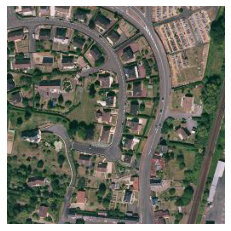

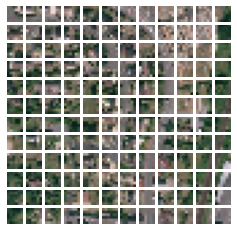

In [18]:
# Visualize patches
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
vit_classifier = create_vit_classifier()

In [11]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']            

                                                                                                  
 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (

 dense_14 (Dense)               (None, 144, 64)      8256        ['dropout_12[0][0]']             
                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_hea

In [27]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        X_train, y_train[:len(X_train)],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
7/7 [==============================] - 15s 664ms/step - loss: 9.5980 - accuracy: 0.0000e+00 - top-5-accuracy: 0.0019 - val_loss: 8.7841 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 2s 334ms/step - loss: 7.6505 - accuracy: 0.0031 - top-5-accuracy: 0.0113 - val_loss: 8.4687 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 2s 335ms/step - loss: 7.1833 - accuracy: 0.0050 - top-5-accuracy: 0.0183 - val_loss: 8.2745 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 2s 335ms/step - loss: 6.8917 - accuracy: 0.0050 - top-5-accuracy: 0.0227 - val_loss: 8.2148 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 2s 335ms/step - loss: 6.7243 - accuracy: 0.0050 - top-5-accuracy: 0.0290 - val_loss: 8.3119 - val_accuracy: 0.0000e+00 - val_top-5-accura

KeyboardInterrupt: 